In [79]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from collections import Counter
import matplotlib as mpl
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
import seaborn as sns
import re

from sklearn.model_selection import train_test_split

In [92]:
df = pd.read_csv('Yummly_Data.csv')

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


# EDA

In [114]:
from plotly.offline import iplot 
import plotly.graph_objs as go

allingredients = [] # this list stores all the ingredients in all recipes (with duplicates)
for item in df['ingredients']:
    for ingr in item:
        allingredients.append(ingr) 

# Count how many times each ingredient occurs
countingr = Counter()
for ingr in allingredients:
     countingr[ingr] += 1

# Extract the first 20 most common ingredients in order to vizualize them for better understanding
mostcommon = countingr.most_common(20)
mostcommoningr = [i[0] for i in mostcommon]
mostcommoningr_count = [i[1] for i in mostcommon]

trace = go.Bar(
            x=mostcommoningr_count[::-1],
            y= mostcommoningr[::-1],
            orientation = 'h',marker = dict(),
)
layout = go.Layout(
    title= 'Most Used Ingredients
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='horizontal-bar')

In [135]:
labelpercents = []
for i in df.cuisine.value_counts():
    percent = (i/sum(df.cuisine.value_counts()))*100
    percent = "%.2f" % percent
    percent = str(percent + '%')
    labelpercents.append(percent)

trace = go.Bar(
            x=df.cuisine.value_counts().values[::-1],
            y= [i for i in df.cuisine.value_counts().index][::-1],
            text =labelpercents[::-1],  textposition = 'outside', 
            orientation = 'h',marker = dict())
layout = go.Layout(title='Percentage of recipes in each cuisine category',
                   )
data = [trace]
fig = dict(data=data, layout=layout)
iplot(fig, filename='horizontal-bar')

In [96]:
#Extract Features
features_all_list = []
for i in df.ingredients:
    features_all_list += i
features = list(set(features_all_list))

In [97]:
#Build DF for DT and RF Analysis
onehot_ingredients = np.zeros((df.shape[0], len(features)))
feature_lookup = sorted(features)

for index, row in df.iterrows():
    for ingredient in row['ingredients']:
        onehot_ingredients[index, feature_lookup.index(ingredient)] = 1

y = df.cuisine.values.reshape(-1,1)

df_features = pd.DataFrame(onehot_ingredients)

d = {}
for i in range(len(features)):
    d[df_features.columns[i]] = features[i]
    
df_features = df_features.rename(columns=d)

In [98]:
#Test/Train for DT and RF Analysis
X_train, X_test, y_train, y_test = train_test_split(df_features, y, test_size=0.3, shuffle=True, random_state=15)

# Decision Tree

In [136]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf = DecisionTreeClassifier(max_features=None)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score in % : ")
print(Accuracy * 100)

Accuracy Score in % : 
61.024050951143884


# Random Forest

In [100]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=None, n_estimators=500, min_samples_split=5)
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score in % : ")
print(Accuracy * 100)

Accuracy Score in % : 
71.2980809519819


In [101]:
#check depth
clf.estimators_[0].tree_.max_depth

437

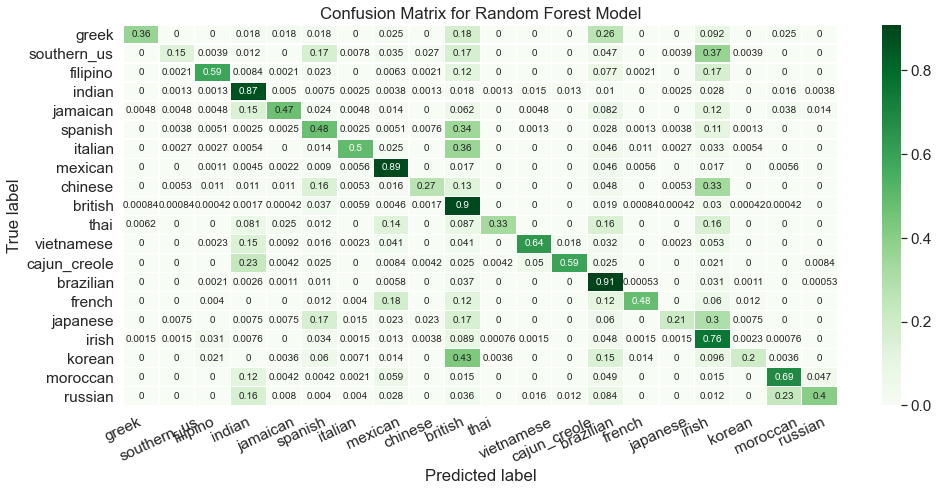

In [104]:
confusion_matrix(y_test, y_pred)

# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['greek', 'southern_us', 'filipino', 
               'indian', 'jamaican', 'spanish',    
               'italian', 'mexican', 'chinese', 'british', 
               'thai', 'vietnamese', 'cajun_creole',    
               'brazilian', 'french', 'japanese', 'irish', 
               'korean', 'moroccan', 'russian']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

Ten_Fold_Accuracy = np.mean(cross_val_score(clf, X_test, y_test, cv=10))
print("10 fold CV Accuracy Score in % : ")
print(Ten_Fold_Accuracy * 100)

In [105]:
#Show Most Important Features
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances[1:25]

,importance
hot red pepper flakes,0.012469
meat filling,0.010791
cuttlefish,0.009071
fresh green peas,0.008712
abura age,0.008686
boar,0.008241
pasta rotel,0.007843
white cornmeal,0.007631
chicken broth low fat,0.007511
wide rice noodles,0.007502
